In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr, entropy
from sklearn.metrics import mutual_info_score
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from scipy.stats import entropy as scipy_entropy

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load the preprocessed EEG data
file_dir = 'Data'
x_path = os.path.join(file_dir, 'x.npy')
y_path = os.path.join(file_dir, 'y.npy')
X = np.load(x_path)
y = np.load(y_path)

# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Create custom datasets and data loaders
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)
test_dataset = EEGDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the EEGNet model
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the client-side and server-side models for different split scenarios
class ClientModel1(nn.Module):
    def __init__(self):
        super(ClientModel1, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        return x

class ServerModel1(nn.Module):
    def __init__(self):
        super(ServerModel1, self).__init__()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ClientModel2(nn.Module):
    def __init__(self):
        super(ClientModel2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        return x

class ServerModel2(nn.Module):
    def __init__(self):
        super(ServerModel2, self).__init__()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ClientModel3(nn.Module):
    def __init__(self):
        super(ClientModel3, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        return x

class ServerModel3(nn.Module):
    def __init__(self):
        super(ServerModel3, self).__init__()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ClientModel4(nn.Module):
    def __init__(self):
        super(ClientModel4, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        return x

class ServerModel4(nn.Module):
    def __init__(self):
        super(ServerModel4, self).__init__()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(256 * 160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ClientModel5(nn.Module):
    def __init__(self):
        super(ClientModel5, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 160, 128)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        return x

class ServerModel5(nn.Module):
    def __init__(self):
        super(ServerModel5, self).__init__()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [2]:
def add_laplace_noise(data, epsilon, sensitivity=1.0):
    """
    Add Laplace noise to the data for differential privacy.
    
    Args:
    - data (torch.Tensor): The data to which noise will be added.
    - epsilon (float): The privacy budget parameter.
    - sensitivity (float): The sensitivity of the data.
    
    Returns:
    - noisy_data (torch.Tensor): The data with added Laplace noise.
    """
    scale = sensitivity / epsilon
    noise = torch.tensor(np.random.laplace(0, scale, data.size()), dtype=torch.float32)
    noisy_data = data + noise
    return noisy_data


In [3]:
def evaluate_model(client_model, server_model, dataloader, scenario, epsilon=None):
    client_model.eval()
    server_model.eval()
    y_true = []
    y_pred = []
    cosine_similarities = []
    pearson_correlations = []
    spearman_correlations = []
    mutual_info_scores = []
    kl_divergences = []
    js_divergences = []
    euclidean_distances = []
    entropies = []

    with torch.no_grad():
        for data, target in dataloader:
            client_output = client_model(data)

            if epsilon:
                client_output = add_laplace_noise(client_output, epsilon)

            server_output = server_model(client_output)
            predictions = (torch.sigmoid(server_output) > 0.5).float().squeeze()
            y_true.extend(target.numpy())
            y_pred.extend(predictions.numpy())

            raw_signal = data.view(data.size(0), -1).numpy()
            intermediate_output = client_output.view(client_output.size(0), -1)
            intermediate_output = nn.functional.interpolate(intermediate_output.unsqueeze(1), size=raw_signal.shape[1], mode='linear', align_corners=False)
            intermediate_output = intermediate_output.squeeze(1).numpy()

            cosine_sim = cosine_similarity(raw_signal, intermediate_output).diagonal()
            cosine_similarities.extend(cosine_sim)

            pearson_corr = np.array([pearsonr(raw_signal[i], intermediate_output[i])[0] for i in range(data.size(0))])
            pearson_correlations.extend(pearson_corr)

            spearman_corr = np.array([spearmanr(raw_signal[i], intermediate_output[i])[0] for i in range(data.size(0))])
            spearman_correlations.extend(spearman_corr)

            mutual_info = np.array([mutual_info_score(raw_signal[i], intermediate_output[i]) for i in range(data.size(0))])
            mutual_info_scores.extend(mutual_info)

            kl_div = np.mean([entropy(raw_signal[i], intermediate_output[i] + 1e-10) for i in range(data.size(0))])  # Add a small epsilon to avoid division by zero
            kl_divergences.append(kl_div)

            js_div = np.mean([0.5 * (entropy(raw_signal[i], intermediate_output[i]) + entropy(intermediate_output[i], raw_signal[i])) for i in range(data.size(0))])
            js_divergences.append(js_div)

            euclidean_dist = np.mean([euclidean(raw_signal[i], intermediate_output[i]) for i in range(data.size(0))])
            euclidean_distances.append(euclidean_dist)

            raw_signal_entropy = np.array([scipy_entropy(raw_signal[i]) for i in range(data.size(0))])
            intermediate_output_entropy = np.array([scipy_entropy(intermediate_output[i]) for i in range(data.size(0))])
            entropies.extend(raw_signal_entropy - intermediate_output_entropy)

    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    avg_cosine_similarity = np.mean(cosine_similarities)
    avg_pearson_correlation = np.mean(pearson_correlations)
    avg_spearman_correlation = np.mean(spearman_correlations)
    avg_mutual_info_score = np.mean(mutual_info_scores)
    avg_kl_divergence = np.mean(kl_divergences)
    avg_js_divergence = np.mean(js_divergences)
    avg_euclidean_distance = np.mean(euclidean_distances)
    client_model_size = sum(p.numel() for p in client_model.parameters())
    avg_entropy_difference = np.mean(entropies)

    print(f"Scenario {scenario}:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print(f"Average Cosine Similarity: {avg_cosine_similarity:.4f}")
    print(f"Average Pearson Correlation: {avg_pearson_correlation:.4f}")
    print(f"Average Spearman Correlation: {avg_spearman_correlation:.4f}")
    print(f"Average Mutual Information Score: {avg_mutual_info_score:.4f}")
    print(f"Average KL Divergence: {avg_kl_divergence:.4f}")
    print(f"Average JS Divergence: {avg_js_divergence:.4f}")
    print(f"Average Euclidean Distance: {avg_euclidean_distance:.4f}")
    print(f"Average Entropy Difference: {avg_entropy_difference:.4f}")
    print(f"Client Model Size: {client_model_size}")
    print()

    return accuracy, avg_cosine_similarity, avg_pearson_correlation, avg_spearman_correlation, avg_mutual_info_score, avg_kl_divergence, avg_js_divergence, avg_euclidean_distance, avg_entropy_difference, client_model_size


In [13]:
# Train and evaluate the model for different split scenarios
scenarios = [
    (ClientModel1(), ServerModel1(), "Breaking at Conv1"),
    (ClientModel2(), ServerModel2(), "Breaking at Conv2"),
    (ClientModel3(), ServerModel3(), "Breaking at Conv3"),
    (ClientModel4(), ServerModel4(), "Breaking at Conv4"),
    (ClientModel5(), ServerModel5(), "Breaking at FC1")
    # (EEGNet(), None, "No Split")
]

results = []
epsilon = 1.0  # Adjust epsilon for the desired level of differential privacy

for i, (client_model, server_model, scenario_name) in enumerate(scenarios):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(list(client_model.parameters()) + (list(server_model.parameters()) if server_model else []), lr=0.001)

    num_epochs = 10
    for epoch in range(num_epochs):
        client_model.train()
        if server_model:
            server_model.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_dataloader):
            client_output = client_model(data)

            if epsilon:
                client_output = add_laplace_noise(client_output, epsilon)

            
            if server_model:
                server_output = server_model(client_output)
                loss = criterion(server_output.squeeze(), target)
            else:
                loss = criterion(client_output.squeeze(), target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        print(f"Scenario {i+1}, Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

    print(f"\nEvaluation Results for Scenario {i+1}:")
    accuracy, cosine_sim, pearson_corr, spearman_corr, mutual_info, kl_div, js_div, euclidean_dist, entropy_diff, model_size = evaluate_model(client_model, server_model, test_dataloader, i+1, epsilon=epsilon)
    results.append((scenario_name, accuracy, cosine_sim, pearson_corr, spearman_corr, mutual_info, kl_div, js_div, euclidean_dist, entropy_diff, model_size))



Scenario 1, Epoch [1/10], Train Loss: 1.3788
Scenario 1, Epoch [2/10], Train Loss: 0.4282
Scenario 1, Epoch [3/10], Train Loss: 0.2693
Scenario 1, Epoch [4/10], Train Loss: 0.1909
Scenario 1, Epoch [5/10], Train Loss: 0.0886
Scenario 1, Epoch [6/10], Train Loss: 0.1035
Scenario 1, Epoch [7/10], Train Loss: 0.0584
Scenario 1, Epoch [8/10], Train Loss: 0.0134
Scenario 1, Epoch [9/10], Train Loss: 0.0316
Scenario 1, Epoch [10/10], Train Loss: 0.0308

Evaluation Results for Scenario 1:


/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received cont

Scenario 1:
Test Accuracy: 0.9542
Confusion Matrix:
[[160   0]
 [ 11  69]]
Average Cosine Similarity: -0.0077
Average Pearson Correlation: -0.0009
Average Spearman Correlation: 0.0001
Average Mutual Information Score: 6.3828
Average KL Divergence: inf
Average JS Divergence: inf
Average Euclidean Distance: 9071.2134
Average Entropy Difference: nan
Client Model Size: 992

Scenario 2, Epoch [1/10], Train Loss: 1.0001
Scenario 2, Epoch [2/10], Train Loss: 0.3494
Scenario 2, Epoch [3/10], Train Loss: 0.2923
Scenario 2, Epoch [4/10], Train Loss: 0.1663
Scenario 2, Epoch [5/10], Train Loss: 0.2286
Scenario 2, Epoch [6/10], Train Loss: 0.1195
Scenario 2, Epoch [7/10], Train Loss: 0.0696
Scenario 2, Epoch [8/10], Train Loss: 0.0496
Scenario 2, Epoch [9/10], Train Loss: 0.0288
Scenario 2, Epoch [10/10], Train Loss: 0.0585

Evaluation Results for Scenario 2:


/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received cont

Scenario 2:
Test Accuracy: 0.8667
Confusion Matrix:
[[134  26]
 [  6  74]]
Average Cosine Similarity: -0.0049
Average Pearson Correlation: -0.0007
Average Spearman Correlation: -0.0017
Average Mutual Information Score: 6.3828
Average KL Divergence: inf
Average JS Divergence: inf
Average Euclidean Distance: 8558.2734
Average Entropy Difference: nan
Client Model Size: 7200

Scenario 3, Epoch [1/10], Train Loss: 1.5764
Scenario 3, Epoch [2/10], Train Loss: 0.4264
Scenario 3, Epoch [3/10], Train Loss: 0.3444
Scenario 3, Epoch [4/10], Train Loss: 0.3179
Scenario 3, Epoch [5/10], Train Loss: 0.3450
Scenario 3, Epoch [6/10], Train Loss: 0.2520
Scenario 3, Epoch [7/10], Train Loss: 0.1938
Scenario 3, Epoch [8/10], Train Loss: 0.1235
Scenario 3, Epoch [9/10], Train Loss: 0.0762
Scenario 3, Epoch [10/10], Train Loss: 0.0562

Evaluation Results for Scenario 3:


/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received cont

Scenario 3:
Test Accuracy: 0.9000
Confusion Matrix:
[[142  18]
 [  6  74]]
Average Cosine Similarity: -0.0067
Average Pearson Correlation: -0.0029
Average Spearman Correlation: -0.0027
Average Mutual Information Score: 6.3828
Average KL Divergence: inf
Average JS Divergence: inf
Average Euclidean Distance: 8549.1972
Average Entropy Difference: nan
Client Model Size: 31904

Scenario 4, Epoch [1/10], Train Loss: 2.3788
Scenario 4, Epoch [2/10], Train Loss: 0.5697
Scenario 4, Epoch [3/10], Train Loss: 0.4444
Scenario 4, Epoch [4/10], Train Loss: 0.4371
Scenario 4, Epoch [5/10], Train Loss: 0.3783
Scenario 4, Epoch [6/10], Train Loss: 0.3482
Scenario 4, Epoch [7/10], Train Loss: 0.3790
Scenario 4, Epoch [8/10], Train Loss: 0.3427
Scenario 4, Epoch [9/10], Train Loss: 0.2087
Scenario 4, Epoch [10/10], Train Loss: 0.1404

Evaluation Results for Scenario 4:


/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received cont

Scenario 4:
Test Accuracy: 0.9417
Confusion Matrix:
[[158   2]
 [ 12  68]]
Average Cosine Similarity: -0.0035
Average Pearson Correlation: -0.0023
Average Spearman Correlation: -0.0007
Average Mutual Information Score: 6.3828
Average KL Divergence: inf
Average JS Divergence: inf
Average Euclidean Distance: 8527.6194
Average Entropy Difference: nan
Client Model Size: 130464

Scenario 5, Epoch [1/10], Train Loss: 0.9786
Scenario 5, Epoch [2/10], Train Loss: 0.4140
Scenario 5, Epoch [3/10], Train Loss: 0.2748
Scenario 5, Epoch [4/10], Train Loss: 0.1676
Scenario 5, Epoch [5/10], Train Loss: 0.0822
Scenario 5, Epoch [6/10], Train Loss: 0.0834
Scenario 5, Epoch [7/10], Train Loss: 0.0312
Scenario 5, Epoch [8/10], Train Loss: 0.0956
Scenario 5, Epoch [9/10], Train Loss: 0.1003
Scenario 5, Epoch [10/10], Train Loss: 0.0782

Evaluation Results for Scenario 5:


/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Users/bchhaglani/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received cont

Scenario 5:
Test Accuracy: 0.9083
Confusion Matrix:
[[160   0]
 [ 22  58]]
Average Cosine Similarity: -0.0030
Average Pearson Correlation: 0.0047
Average Spearman Correlation: 0.0043
Average Mutual Information Score: 6.3493
Average KL Divergence: inf
Average JS Divergence: inf
Average Euclidean Distance: 8679.2784
Average Entropy Difference: nan
Client Model Size: 5373472

Scenario 6, Epoch [1/10], Train Loss: 1.2749
Scenario 6, Epoch [2/10], Train Loss: 0.5855
Scenario 6, Epoch [3/10], Train Loss: 0.5076
Scenario 6, Epoch [4/10], Train Loss: 0.3031
Scenario 6, Epoch [5/10], Train Loss: 0.2043
Scenario 6, Epoch [6/10], Train Loss: 0.1005
Scenario 6, Epoch [7/10], Train Loss: 0.0799
Scenario 6, Epoch [8/10], Train Loss: 0.0404
Scenario 6, Epoch [9/10], Train Loss: 0.0286
Scenario 6, Epoch [10/10], Train Loss: 0.1344

Evaluation Results for Scenario 6:


AttributeError: 'NoneType' object has no attribute 'eval'

Summary of Results:
Scenario: Breaking at Conv1
Test Accuracy: 0.9542
Cosine Similarity: -0.0077
Pearson Correlation: -0.0009
Spearman Correlation: 0.0001
Mutual Information: 6.3828
KL Divergence: inf
JS Divergence: inf
Euclidean Distance: 9071.2134
Client Model Size: 992
Entropy Difference: nan

Scenario: Breaking at Conv2
Test Accuracy: 0.8667
Cosine Similarity: -0.0049
Pearson Correlation: -0.0007
Spearman Correlation: -0.0017
Mutual Information: 6.3828
KL Divergence: inf
JS Divergence: inf
Euclidean Distance: 8558.2734
Client Model Size: 7200
Entropy Difference: nan

Scenario: Breaking at Conv3
Test Accuracy: 0.9000
Cosine Similarity: -0.0067
Pearson Correlation: -0.0029
Spearman Correlation: -0.0027
Mutual Information: 6.3828
KL Divergence: inf
JS Divergence: inf
Euclidean Distance: 8549.1972
Client Model Size: 31904
Entropy Difference: nan

Scenario: Breaking at Conv4
Test Accuracy: 0.9417
Cosine Similarity: -0.0035
Pearson Correlation: -0.0023
Spearman Correlation: -0.0007
Mutua

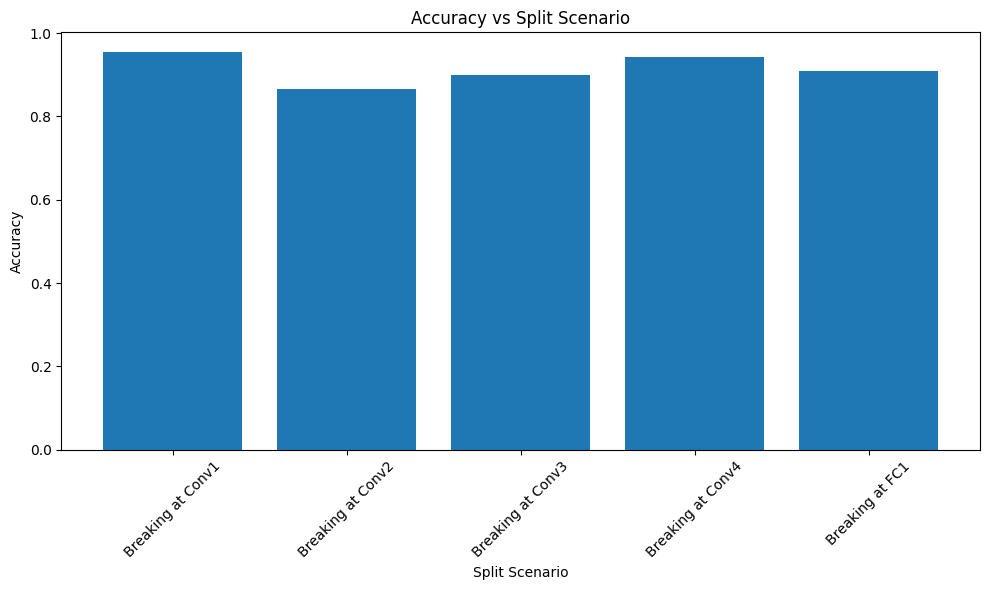

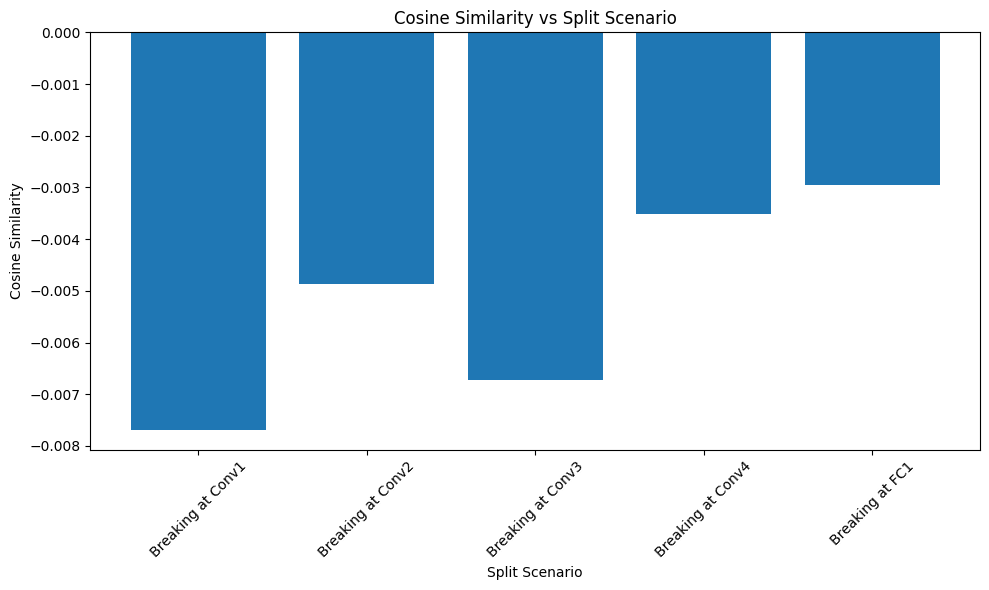

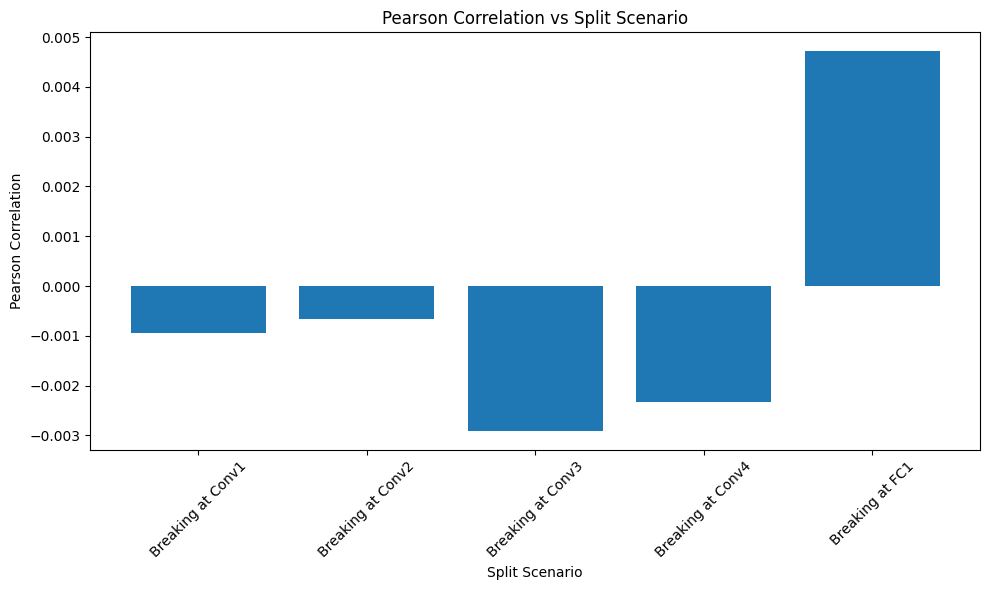

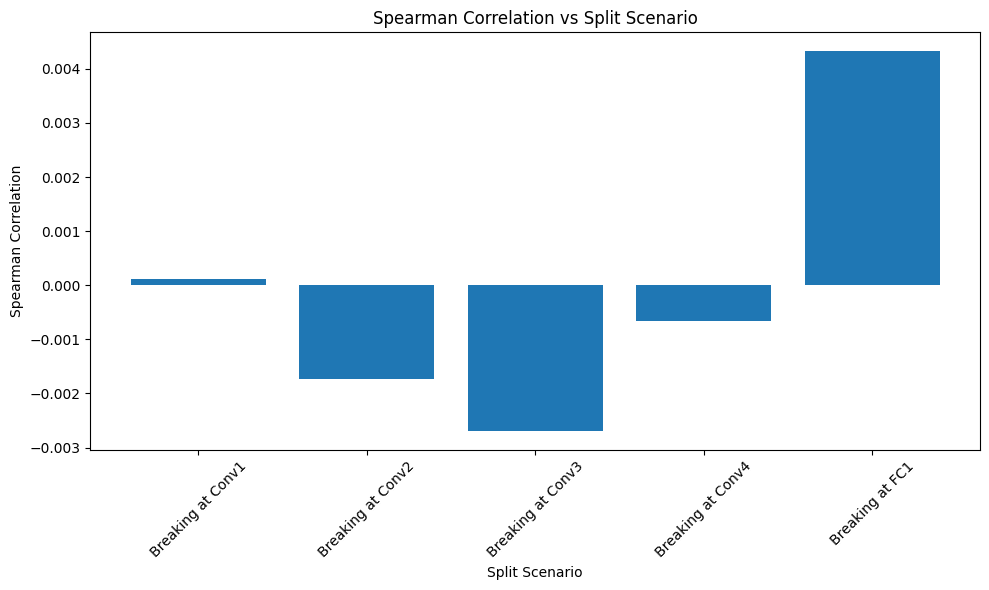

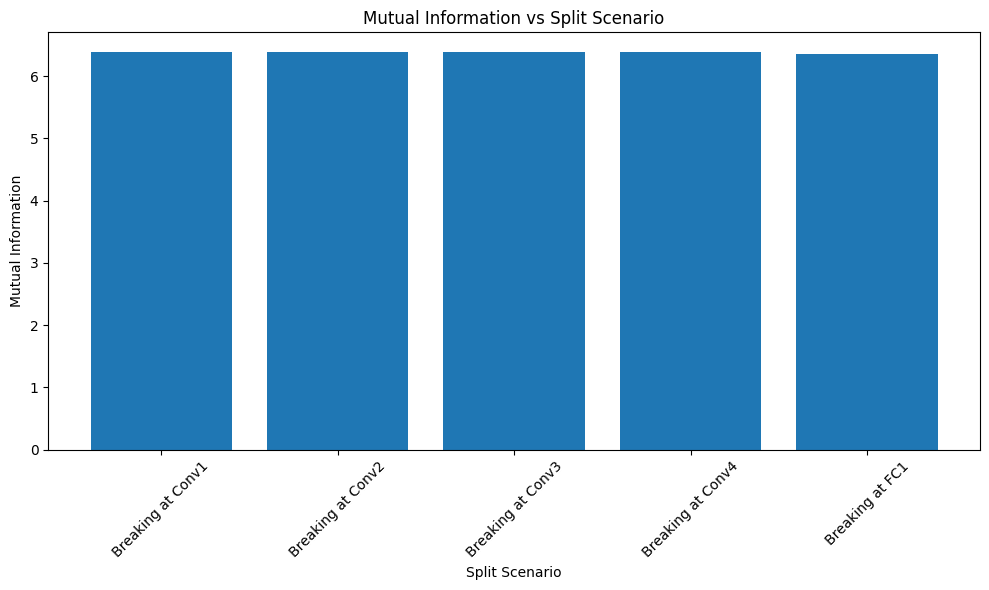

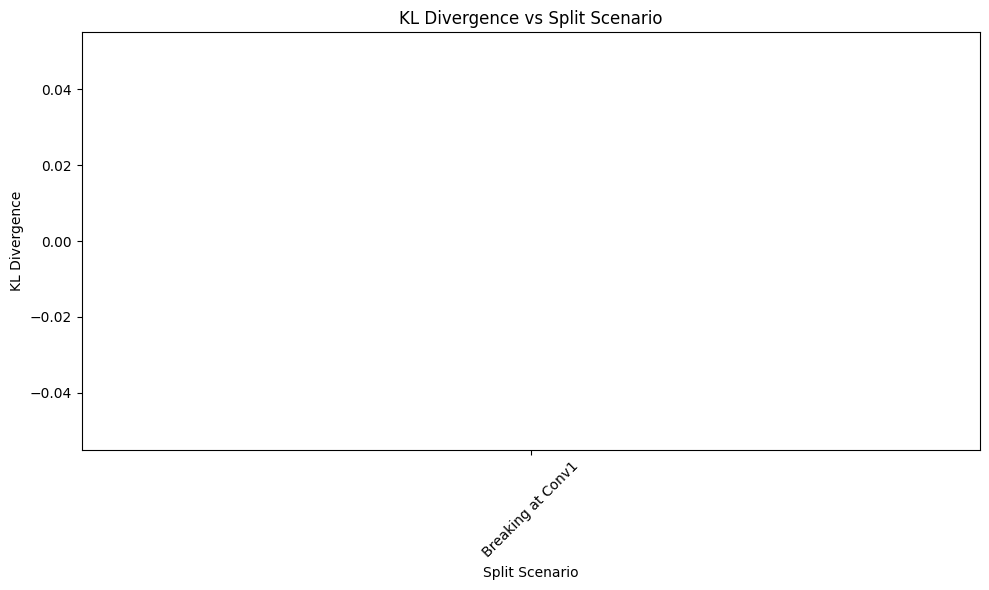

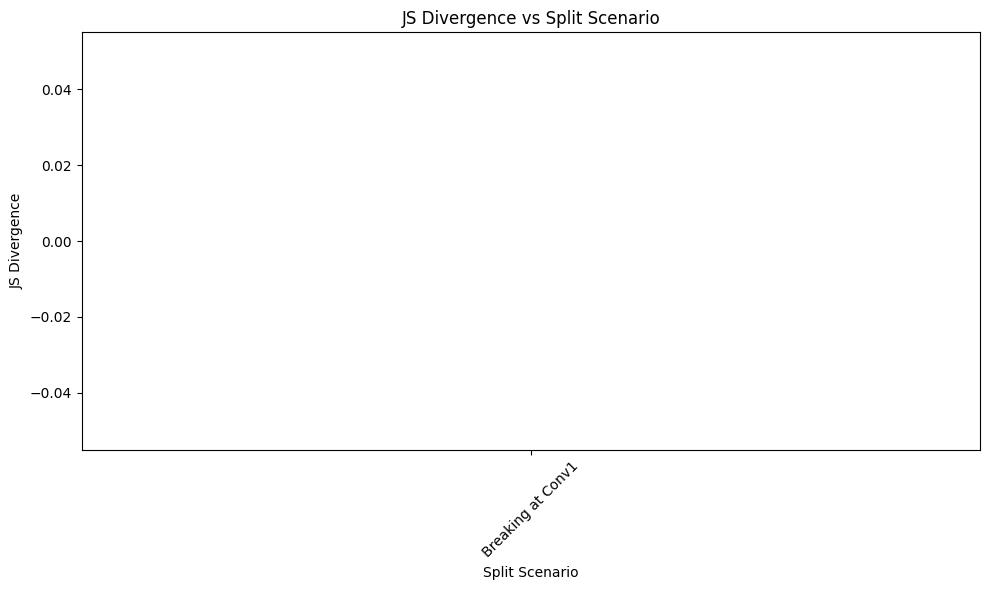

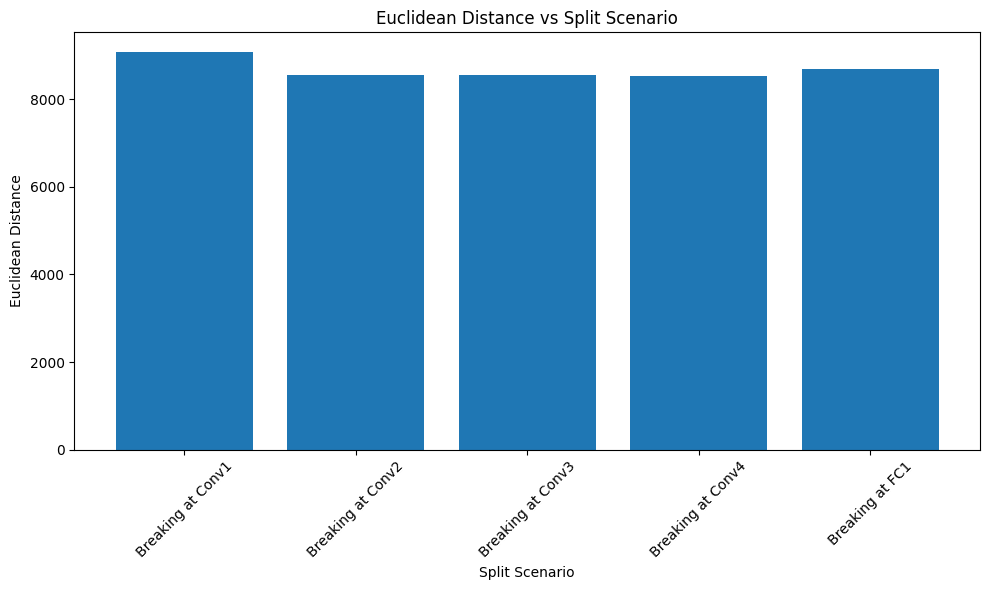

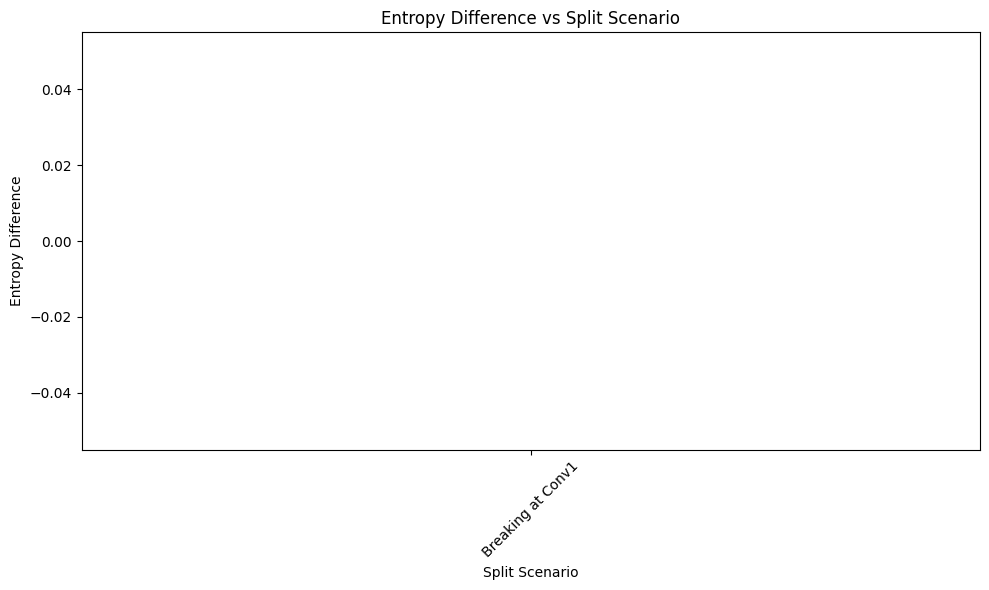

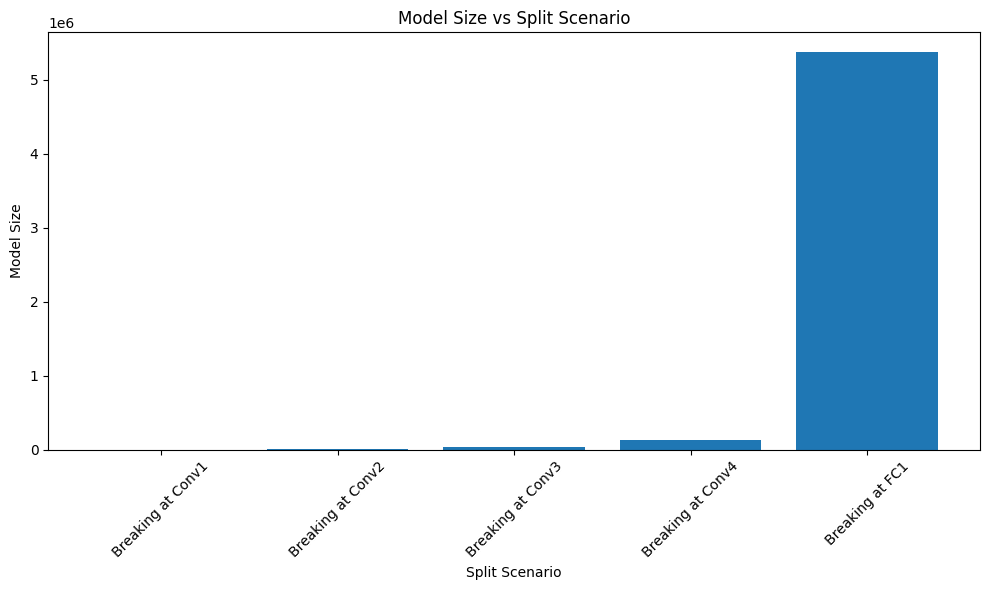

In [16]:
print("Summary of Results:")
for scenario_name, accuracy, cosine_sim, pearson_corr, spearman_corr, mutual_info, kl_div, js_div, euclidean_dist, entropy_diff, model_size in results:
    print(f"Scenario: {scenario_name}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Cosine Similarity: {cosine_sim:.4f}")
    print(f"Pearson Correlation: {pearson_corr:.4f}")
    print(f"Spearman Correlation: {spearman_corr:.4f}")
    print(f"Mutual Information: {mutual_info:.4f}")
    print(f"KL Divergence: {kl_div:.4f}")
    print(f"JS Divergence: {js_div:.4f}")
    print(f"Euclidean Distance: {euclidean_dist:.4f}")
    print(f"Client Model Size: {model_size}")
    print(f"Entropy Difference: {entropy_diff:.4f}")
    print()

# Visualize the results
metrics = ['Accuracy', 'Cosine Similarity', 'Pearson Correlation', 'Spearman Correlation', 'Mutual Information', 'KL Divergence', 'JS Divergence', 'Euclidean Distance', 'Entropy Difference', 'Model Size']
scenarios = [result[0] for result in results]

for metric in metrics:
    values = [result[metrics.index(metric) + 1] for result in results]
    plt.figure(figsize=(10, 6))
    plt.bar(scenarios, values)
    plt.xlabel('Split Scenario')
    plt.ylabel(metric)
    plt.title(f'{metric} vs Split Scenario')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
##Visualize Results

In [ ]:
import matplotlib.pyplot as plt

# Privacy metrics data
scenarios = ['Conv1', 'Conv2', 'Conv3', 'Conv4', 'FC1']
cosine_similarity = [-0.0070, -0.0058, -0.0057, -0.0021, -0.0053]
pearson_correlation = [-0.0003, -0.0010, -0.0016, -0.0010, 0.0025]
spearman_correlation = [-0.0022, 0.0001, -0.0019, -0.0011, 0.0044]
mutual_information = [3.8395, 2.2395, 1.6687, 0.2306, 3.3381]
euclidean_distance = [9070.0681, 8553.1258, 8522.7265, 8517.3554, 8719.1358]
dtw_distance = [968043.3972, 941524.4162, 966600.4249, 970658.5830, 966105.4495]

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Privacy Metrics for Different Scenarios', fontsize=16)

# Cosine Similarity
axs[0, 0].plot(scenarios, cosine_similarity, marker='o')
axs[0, 0].set_title('Cosine Similarity')
axs[0, 0].set_xticklabels(scenarios,  ha='right')
axs[0, 0].set_ylim(min(cosine_similarity) - 0.001, max(cosine_similarity) + 0.001)

# Pearson Correlation
axs[0, 1].plot(scenarios, pearson_correlation, marker='o')
axs[0, 1].set_title('Pearson Correlation')
axs[0, 1].set_xticklabels(scenarios,  ha='right')
axs[0, 1].set_ylim(min(pearson_correlation) - 0.001, max(pearson_correlation) + 0.001)

# Spearman Correlation
axs[0, 2].plot(scenarios, spearman_correlation, marker='o')
axs[0, 2].set_title('Spearman Correlation')
axs[0, 2].set_xticklabels(scenarios,  ha='right')
axs[0, 2].set_ylim(min(spearman_correlation) - 0.001, max(spearman_correlation) + 0.001)

# Mutual Information
axs[1, 0].plot(scenarios, mutual_information, marker='o')
axs[1, 0].set_title('Mutual Information')
axs[1, 0].set_xticklabels(scenarios,  ha='right')
axs[1, 0].set_ylim(min(mutual_information) - 0.1, max(mutual_information) + 0.1)

# Euclidean Distance
axs[1, 1].plot(scenarios, euclidean_distance, marker='o')
axs[1, 1].set_title('Euclidean Distance')
axs[1, 1].set_xticklabels(scenarios, ha='right')
axs[1, 1].set_ylim(min(euclidean_distance) - 100, max(euclidean_distance) + 100)

# DTW Distance
axs[1, 2].plot(scenarios, dtw_distance, marker='o')
axs[1, 2].set_title('DTW Distance')
axs[1, 2].set_xticklabels(scenarios,  ha='right')
axs[1, 2].set_ylim(min(dtw_distance) - 10000, max(dtw_distance) + 10000)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plots
plt.show()